# Gradient Boosting

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb

In [73]:
plt.rcParams['figure.figsize'] = [10,9]

In [58]:
data = pd.read_excel("InflationsHistorical.xlsx")
data['Date'] = pd.date_range(start = '2011-01', end = '2022-06', freq='M')
#data.set_index('Date', inplace = True)
#data.sort_index(ascending = True, inplace = True)
data

,Date,Core CPI,Fruits & Vegetables
0,2011-01-31,0.001678,0.023805
1,2011-02-28,0.001134,-0.003334
2,2011-03-31,-0.001650,0.195990
3,2011-04-30,0.008472,0.059881
4,2011-05-31,0.005371,-0.044851
...,...,...,...
132,2022-01-31,0.011640,0.151650
133,2022-02-28,0.030930,-0.018840
134,2022-03-31,0.024020,0.276020
135,2022-04-30,0.015890,-0.100630


In [59]:
def lags(x, lag):
    lags = pd.DataFrame()
    for i in range(1, lag+1):
        lagged = x.shift(i)
        lags[f'lag {i}'] = lagged
    return lags  

In [60]:
y_train = data['Core CPI'].iloc[:-37]
y_test = data['Core CPI'].iloc[-37:,]

X_train = lags(y_train, 12)
X_test = lags(y_test, 12)

In [83]:
xgb0 = xgb.XGBRegressor(
    learning_rate = 0.3,
    n_estimators = 500)

xgbtrain = xgb.DMatrix(X_train, y_train)

cvresults = xgb.cv(
    xgb0.get_params(),
    xgbtrain,
    num_boost_round= xgb0.get_params()['n_estimators'],
    early_stopping_rounds = 50,
    metrics='rmse',
    folds=TimeSeriesSplit(3)
    )
xgb1 = xgb0.set_params(n_estimators = cvresults.shape[0])

params = {
    'learning_rate':[0.01, 0.1, 0.3, 0.7],
    'max_depth':[1,2,5,7, 8],
    'min_child_weight':range(1,3)
}

gridsearch = GridSearchCV(xgb1, param_grid = params, cv = TimeSeriesSplit(3), n_jobs=-1).fit(X_train,y_train)

xgb2 = xgb1.set_params(
    max_depth = gridsearch.best_params_['max_depth'],
    learning_rate = gridsearch.best_params_['learning_rate']
)
best_params = xgb2.fit(X_train, y_train).get_params()
best_params

[18:36:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "enable_categorical", "missing", "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:36:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "enable_categorical", "missing", "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:36:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 1,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 18,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [14]:
def rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

Train error: 0.00181350912511062, Test error: 0.010542940019969537


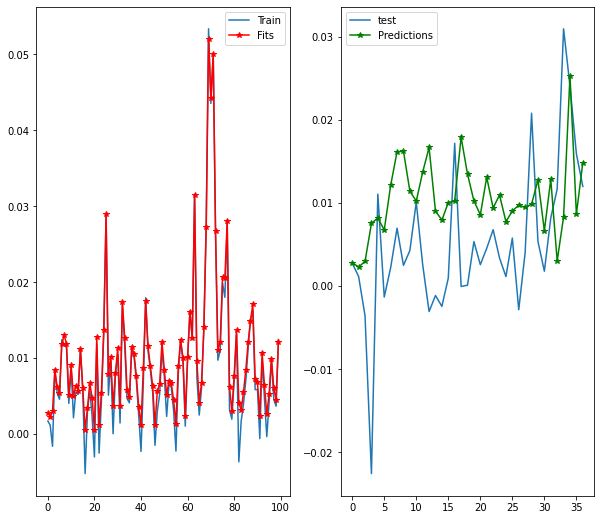

In [88]:
model = xgb.XGBRegressor(learning_rate = 0.3, n_estimators = 18, max_depth = 8).fit(X_train, y_train)
y_fits = model.predict(X_train)
y_pred = model.predict(X_test)

train_error, test_error = rmse(y_train, y_fits), rmse(y_test, y_pred)
print(f'Train error: {train_error}, Test error: {test_error}')
plt.subplot(1,2,1)
plt.plot(y_train, label = 'Train')
plt.plot(y_fits, label = 'Fits', color = 'red', marker = "*")
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_test.reset_index(drop=True), label = "test")
plt.plot(y_pred, marker = "*", label = 'Predictions', color = 'green')
plt.legend()
plt.show()